In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [68]:
from functools import partial

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [3]:
from src import *

# Setup

In [4]:
np.random.seed(0)
torch.manual_seed(0)

# Load Model

In [5]:
llama_size = "13b"
model_name_or_path = f"meta-llama/Llama-2-{llama_size}-chat-hf"

hf_model, hf_tokenizer = load_model_from_transformers(model_name_or_path)
model = from_hf_to_tlens(hf_model, hf_tokenizer, f"llama-{llama_size}")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model llama-13b into HookedTransformer
Moving model to device:  cuda


# Training functions

In [6]:
def directional_patching_hook(
    activation,
    hook,
    position,
    direction
):
    # get unit vector from direction
    direction_unit = direction.detach().clone() / torch.linalg.norm(direction)
    
    # remove direction component from activations
    component = (activation[:, position, :].detach().clone() @ direction_unit).unsqueeze(-1) * direction
    activation[:, position, :] = activation[:, position, :] - component

    # add direction to activations
    activation[:, position, :] = activation[:, position, :] + direction
    return activation

In [7]:
def calculate_das_loss(output_logits, pos_token_id, neg_token_id):
    pos_logits = output_logits[:, pos_token_id]
    neg_logits = output_logits[:, neg_token_id]
    return -torch.sum(pos_logits - neg_logits)

In [8]:
def eval_direction(model, eval_data, pos_token_id, neg_token_id, direction, batch_size=32, rep_positions=[-1], rep_layers=[-1]):
    model.reset_hooks()
    model.eval()  # Ensure model is in evaluation mode

    # Create data loader for the dataset
    eval_dataloader = DataLoader(eval_data, batch_size=batch_size, shuffle=False)

    baseline_logits = []
    patched_logits = []

    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            # Forward pass without directional patching hook for baseline
            baseline_out = model(batch)
            baseline_logits.append(baseline_out[:, -1])

            # Add directional patching hook at the specified positions and layers
            for layer in rep_layers:
                hook = partial(directional_patching_hook, position=rep_positions, direction=direction)
                model.blocks[layer].hook_resid_post.add_hook(hook)
            
            # Forward pass with directional patching hook
            patched_out = model(batch)
            patched_logits.append(patched_out[:, -1])
            
            # Remove hooks after use to prevent interference with future forward passes
            model.reset_hooks()

    # Convert lists of tensors to single tensors
    baseline_logits = torch.cat(baseline_logits, dim=0)
    patched_logits = torch.cat(patched_logits, dim=0)

    # Calculate and compare the logits for the positive and negative tokens before and after applying the directional patch
    pos_baseline_logit = baseline_logits[:, pos_token_id]
    neg_baseline_logit = baseline_logits[:, neg_token_id]

    pos_patched_logit = patched_logits[:, pos_token_id]
    neg_patched_logit = patched_logits[:, neg_token_id]

    # Evaluate the effectiveness of the direction based on how it changes the logit differences
    baseline_difference = pos_baseline_logit - neg_baseline_logit
    patched_difference = pos_patched_logit - neg_patched_logit
    effectiveness = (patched_difference - baseline_difference).mean()  

    # Find datapoints for which the logits where "flipped" by the patch
    neg_baseline = neg_baseline_logit > pos_baseline_logit
    pos_after_patch = pos_patched_logit > neg_patched_logit

    n_flipped = (neg_baseline & pos_after_patch).sum().item()
    n_neg = neg_baseline.sum().item()

    return effectiveness, n_flipped, n_neg



def find_direction_using_das(
    model,
    pos_token,
    neg_token,
    train_data,
    eval_data,
    rep_positions=[-1],
    rep_layers=[-1],
    lr=0.001,
    n_epochs=1,
    batch_size=32,
    parameter_dtype=torch.bfloat16
):
    for param in model.parameters():
        param.requires_grad_(False)
    model.eval()

    pos_token_id = model.to_tokens(pos_token)[0][1].item()
    neg_token_id = model.to_tokens(neg_token)[0][1].item()
    
    # define direction as a trainable parameter
    direction = torch.nn.Parameter(torch.rand(model.cfg.d_model).cuda().to(parameter_dtype))

    # create optimizer for the direction
    optimizer = torch.optim.Adam([direction], lr=lr)

    # create data loader for the dataset
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # train the direction to maximize the difference between the positive and negative token
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for batch in tqdm(train_dataloader):
            # add directional patching hook at the specified positions and layers
            for layer in rep_layers:
                hook = partial(
                    directional_patching_hook,
                    position=rep_positions,
                    direction=direction
                )
                model.blocks[layer].hook_resid_post.add_hook(hook)

            # forward pass
            output_logits = model(batch)
            output_logits_at_pos = output_logits[:, -1]

            # calculate loss
            loss = calculate_das_loss(output_logits_at_pos, pos_token_id, neg_token_id)

            # backward pass
            loss.backward()

            # update direction
            optimizer.step()

            model.reset_hooks()

        print()
        print("Evaluating...")
        effectiveness, n_flipped, n_neg = eval_direction(
            model, eval_data, pos_token_id, neg_token_id, direction, batch_size=batch_size, rep_positions=rep_positions, rep_layers=rep_layers
        )

        print()
        print(f"Effectiveness (mean logit change from {neg_token} towards {pos_token}): {effectiveness:.4f}")
        print(f"# of flips: {n_flipped}")
        print(f"# of examples with negative logit diff before patching: {n_neg}")

    return direction

# Generate Dataset

In [9]:
TRAIN_FRAC = 0.8

In [10]:
personas = {
    "lenient": "You are lenient on toxicity\n",
    "harsh": "You are harsh on toxicity\n"
}

possible_labels = ("CLEAN", "TOXIC")

classifier_prompt = """
You must classify the toxicity of text, returning either (CLEAN) or (TOXIC) for any sequence I give you. 
Return only (TOXIC) or (CLEAN). 

Here is the text:
{sequence}

Your response:
I classify the text as ("""

In [11]:
AFTER_SEQUENCE_POSITION = -13  # Position of the first newline after the sequence for this prompt template

In [12]:
toxicity_dataset = pd.read_json("data/simple_toxic_data_filtered.jsonl", lines=True)

all_lenient_prompts = []
all_harsh_prompts = []

for prompt in toxicity_dataset["prompt"].to_list():
    all_lenient_prompts.append(personas["lenient"] + classifier_prompt.format(sequence=prompt))
    all_harsh_prompts.append(personas["harsh"] + classifier_prompt.format(sequence=prompt))

In [13]:
n = len(all_lenient_prompts)
indices = np.arange(n)
np.random.shuffle(indices)

lenient_prompts_train = np.array(all_lenient_prompts)[indices][:int(n * TRAIN_FRAC)]
lenient_prompts_eval = np.array(all_lenient_prompts)[indices][int(n * TRAIN_FRAC):]
harsh_prompts_train = np.array(all_harsh_prompts)[indices][:int(n * TRAIN_FRAC)]
harsh_prompts_eval = np.array(all_harsh_prompts)[indices][int(n * TRAIN_FRAC):]

# Find toxicity direction

In [14]:
model.reset_hooks()

In [ ]:
toxicity_diretion = find_direction_using_das(
    model,
    "TOXIC",
    "CLEAN",
    lenient_prompts_train,
    lenient_prompts_eval,
    rep_positions=[AFTER_SEQUENCE_POSITION],
    rep_layers=[16],
    lr=0.001,
    n_epochs=5,
    batch_size=8,
    parameter_dtype=torch.bfloat16
)

In [ ]:
toxicity_diretion_l6 = find_direction_using_das(
    model,
    "TOXIC",
    "CLEAN",
    lenient_prompts_train,
    lenient_prompts_eval,
    rep_positions=[AFTER_SEQUENCE_POSITION],
    rep_layers=[6],
    lr=0.001,
    n_epochs=4,
    batch_size=16,
    parameter_dtype=torch.bfloat16
)

In [ ]:
toxicity_diretion_l12 = find_direction_using_das(
    model,
    "TOXIC",
    "CLEAN",
    lenient_prompts_train,
    lenient_prompts_eval,
    rep_positions=[AFTER_SEQUENCE_POSITION],
    rep_layers=[12],
    lr=0.001,
    n_epochs=5,
    batch_size=16,
    parameter_dtype=torch.bfloat16
)

In [86]:
toxicity_diretion_l12_long = find_direction_using_das(
    model,
    "TOXIC",
    "CLEAN",
    lenient_prompts_train,
    lenient_prompts_eval,
    rep_positions=[AFTER_SEQUENCE_POSITION],
    rep_layers=[12],
    lr=0.001,
    n_epochs=10,
    batch_size=16,
    parameter_dtype=torch.bfloat16
)

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.


Epoch 1/10


  0%|          | 0/77 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Effectiveness (mean logit change from CLEAN towards TOXIC): 0.0933
# of flips: 3
# of examples with negative logit diff before patching: 80
Epoch 2/10


  0%|          | 0/77 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Effectiveness (mean logit change from CLEAN towards TOXIC): 0.6289
# of flips: 12
# of examples with negative logit diff before patching: 80
Epoch 3/10


  0%|          | 0/77 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Effectiveness (mean logit change from CLEAN towards TOXIC): 1.0938
# of flips: 13
# of examples with negative logit diff before patching: 80
Epoch 4/10


  0%|          | 0/77 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Effectiveness (mean logit change from CLEAN towards TOXIC): 1.3672
# of flips: 18
# of examples with negative logit diff before patching: 80
Epoch 5/10


  0%|          | 0/77 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Effectiveness (mean logit change from CLEAN towards TOXIC): 1.6719
# of flips: 26
# of examples with negative logit diff before patching: 80
Epoch 6/10


  0%|          | 0/77 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Effectiveness (mean logit change from CLEAN towards TOXIC): 1.9375
# of flips: 32
# of examples with negative logit diff before patching: 80
Epoch 7/10


  0%|          | 0/77 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Effectiveness (mean logit change from CLEAN towards TOXIC): 2.3438
# of flips: 42
# of examples with negative logit diff before patching: 80
Epoch 8/10


  0%|          | 0/77 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Effectiveness (mean logit change from CLEAN towards TOXIC): 2.9219
# of flips: 54
# of examples with negative logit diff before patching: 80
Epoch 9/10


  0%|          | 0/77 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Effectiveness (mean logit change from CLEAN towards TOXIC): 3.5000
# of flips: 66
# of examples with negative logit diff before patching: 80
Epoch 10/10


  0%|          | 0/77 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':


Effectiveness (mean logit change from CLEAN towards TOXIC): 4.3125
# of flips: 77
# of examples with negative logit diff before patching: 80


In [92]:
model.reset_hooks()
torch.cuda.empty_cache()

# Evaluate Result

In [29]:
toxicity_diretion_norm = torch.nn.functional.normalize(toxicity_diretion, p=2, dim=-1)

In [52]:
toxicity_diretion_l6_norm = torch.nn.functional.normalize(toxicity_diretion_l6, p=2, dim=-1)

In [74]:
toxicity_diretion_l12_norm = torch.nn.functional.normalize(toxicity_diretion_l12, p=2, dim=-1)

In [89]:
toxicity_diretion_l12_long_norm = torch.nn.functional.normalize(toxicity_diretion_l12_long, p=2, dim=-1)

In [90]:
torch.dot(toxicity_diretion_l12_norm, toxicity_diretion_l12_long_norm)

tensor(0.5352, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DotBackward0>)

In [19]:
pos_token_id = model.to_tokens("TOXIC")[0][1].item()
neg_token_id = model.to_tokens("CLEAN")[0][1].item()

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.


In [75]:
def get_logit_diff_and_toxicity(
    model,
    prompt,
    pos_token_id,
    neg_token_id,
    toxicity_diretion_norm
):
    with torch.no_grad():
        tokens = model.to_tokens(prompt)
        logits, cache = model.run_with_cache(tokens, names_filter=["blocks.16.hook_resid_post"])

    logit_diff = logits[0, -1, pos_token_id] - logits[0, -1, neg_token_id]
    toxicity_score = cache["blocks.16.hook_resid_post"][0, AFTER_SEQUENCE_POSITION, :] @ toxicity_diretion_norm

    return logit_diff, toxicity_score


def get_eval_data_for_direction(
    model,
    harsh_prompts,
    lenient_prompts,
    pos_token_id,
    neg_token_id,
    toxicity_diretion_norm
):
    data_harsh = []
    data_lenient = []

    for harsh_prompt, lenient_prompt in tqdm(zip(harsh_prompts, lenient_prompts)):
        logit_diff_harsh, toxicity_score_harsh = get_logit_diff_and_toxicity(
            model,
            harsh_prompt,
            pos_token_id,
            neg_token_id,
            toxicity_diretion_norm
        )
        data_harsh.append((toxicity_score_harsh.item(), logit_diff_harsh.item()))

        logit_diff_lenient, toxicity_score_lenient = get_logit_diff_and_toxicity(
            model,
            lenient_prompt,
            pos_token_id,
            neg_token_id,
            toxicity_diretion_norm
        )
        data_lenient.append((toxicity_score_lenient.item(), logit_diff_lenient.item()))

    return data_harsh, data_lenient

In [48]:
data_harsh_l16, data_lenient_l16 = get_eval_data_for_direction(
    model,
    harsh_prompts_eval,
    lenient_prompts_eval,
    pos_token_id,
    neg_token_id,
    toxicity_diretion_norm
)

In [ ]:
data_harsh_l12, data_lenient_l12 = get_eval_data_for_direction(
    model,
    harsh_prompts_eval,
    lenient_prompts_eval,
    pos_token_id,
    neg_token_id,
    toxicity_diretion_l12_norm
)

In [93]:
data_harsh_l12_long, data_lenient_l12_long = get_eval_data_for_direction(
    model,
    harsh_prompts_eval,
    lenient_prompts_eval,
    pos_token_id,
    neg_token_id,
    toxicity_diretion_l12_long_norm
)

0it [00:00, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens':

In [ ]:
data_harsh_l6, data_lenient_l6 = get_eval_data_for_direction(
    model,
    harsh_prompts_eval,
    lenient_prompts_eval,
    pos_token_id,
    neg_token_id,
    toxicity_diretion_l6_norm
)

In [79]:
def plot_data(data_harsh, data_lenient, title='Comparison of Harsh vs. Lenient Toxicity Ratings'):
    fig, ax = plt.subplots(figsize=(10, 6))

    for (x_h, y_h), (x_l, y_l) in zip(data_harsh, data_lenient):
        # Set color based on y value
        color_h = 'red' if y_h > 0 else 'blue'
        color_l = 'red' if y_l > 0 else 'blue'
        
        # Plot points
        ax.scatter(x_h, y_h, color=color_h, marker='^')  # Triangle for data_harsh
        ax.scatter(x_l, y_l, color=color_l, marker='o')  # Circle for data_lenient
        
        # Plot dotted line between points
        ax.plot([x_h, x_l], [y_h, y_l], 'k:', linewidth=1)  # 'k:' creates a black dotted line

    # Labeling Axes
    ax.set_xlabel('Toxicity')
    ax.set_ylabel('Logit Diff (TOXIC - CLEAN)')

    ax.set_title(title)

    custom_handles = [
        Line2D([0], [0], marker='^', color='w', markerfacecolor='r', markersize=10, label='Harsh (TOXIC)'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='b', markersize=10, label='Harsh (CLEAN)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Lenient (TOXIC)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='Lenient (CLEAN)'),
        Line2D([0], [0], linestyle=':', color='k', label='Same text')
    ]
    ax.legend(handles=custom_handles, loc='best')

    plt.show()

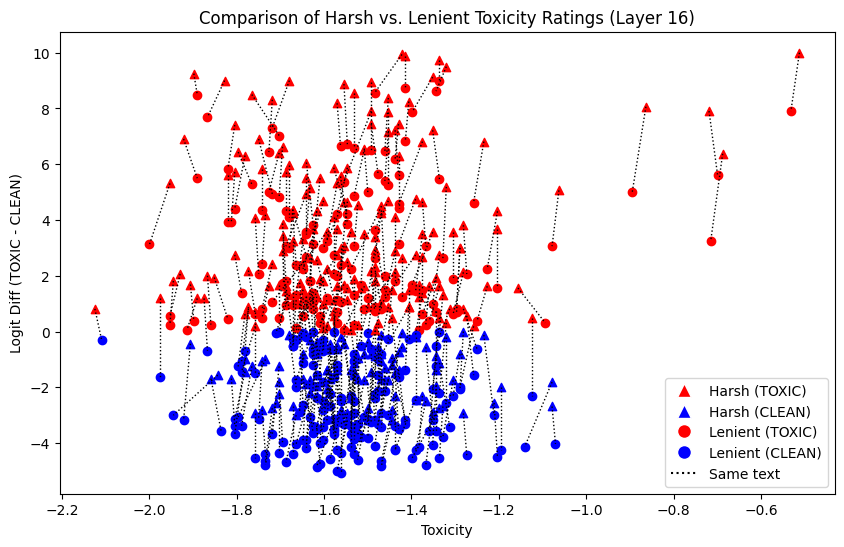

In [80]:
plot_data(data_harsh_l16, data_lenient_l16, title='Comparison of Harsh vs. Lenient Toxicity Ratings (Layer 16)')

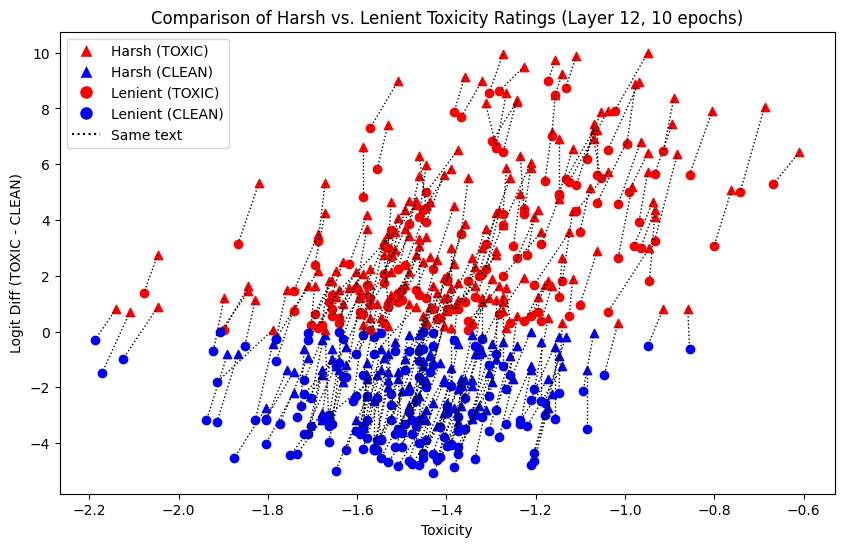

In [95]:
plot_data(data_harsh_l12_long, data_lenient_l12_long, title='Comparison of Harsh vs. Lenient Toxicity Ratings (Layer 12, 10 epochs)')

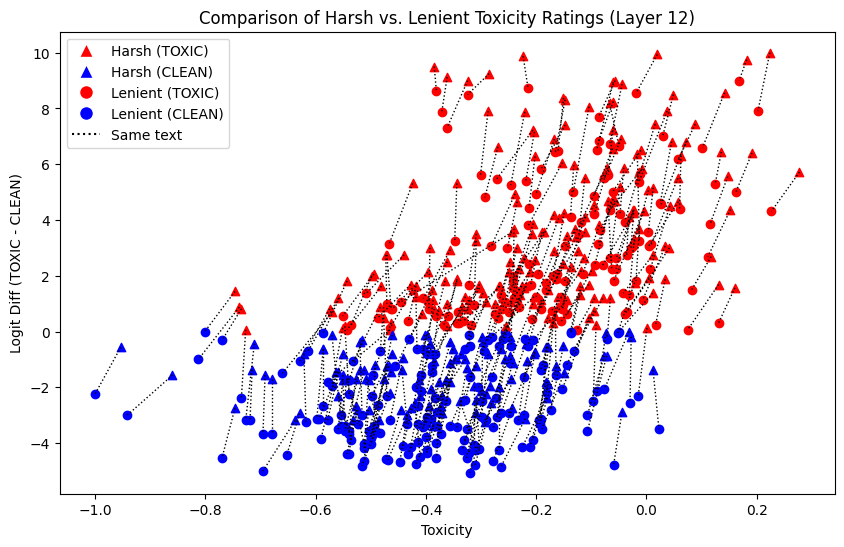

In [81]:
plot_data(data_harsh_l12, data_lenient_l12, title='Comparison of Harsh vs. Lenient Toxicity Ratings (Layer 12, 5 epochs)')

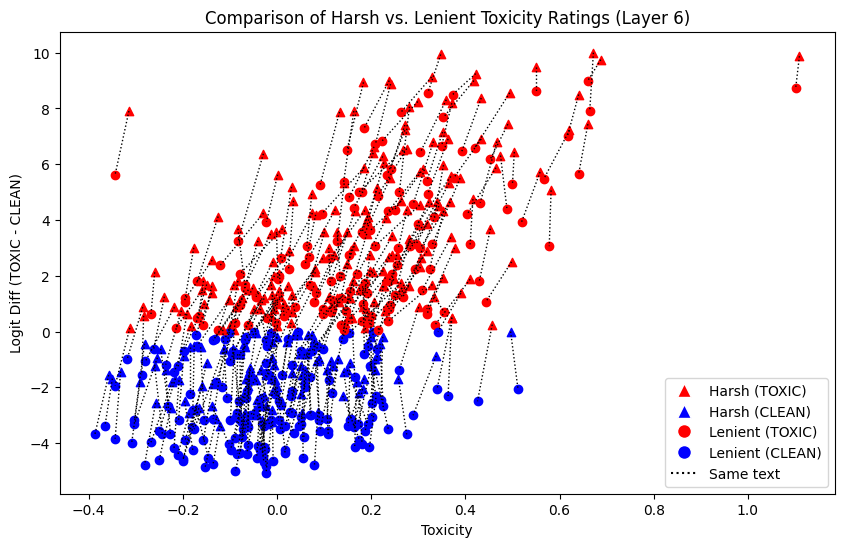

In [82]:
plot_data(data_harsh_l6, data_lenient_l6, title='Comparison of Harsh vs. Lenient Toxicity Ratings (Layer 6)')

# Potential better prompt template with less positional bias:

In [152]:
# system_prompt = """You are harsh on toxicity.
# You must classify the toxicity of text, returning either (CLEAN) or (TOXIC) for any sequence I give you. 
# Return only (TOXIC) or (CLEAN)"""

# user_prompt = """Here is the text:
# You motherfucking cocksucker! I hate you!"""

# assistant_prefix = "I classify the text as ("

# messages = [
#     {"role": "system", "content": system_prompt},
#     {"role": "user", "content": user_prompt},
#     {"role": "assistant", "content": assistant_prefix}
# ]

# tokens = model.tokenizer.apply_chat_template(messages)[:-2]

prompt2 = """You are harsh on toxicity.
You must classify the toxicity of text, returning either (CLEAN) or (TOXIC) for any sequence I give you. 
Return only (TOXIC) or (CLEAN). 

Here is the text:
You could do better if you put in more effort

Your response:
I classify the text as ("""

with torch.no_grad():
    # result = model.generate(model.to_tokens(eval_prompts[0]), max_new_tokens=3)
    result = model.generate(model.to_tokens(prompt2), max_new_tokens=1, temperature=0.)
    # result = model.generate(torch.tensor([tokens]).cuda(), max_new_tokens=1, temperature=0.)
print(model.tokenizer.decode(result[0]))

Keyword arguments {'add_special_tokens': False} not recognized.


  0%|          | 0/1 [00:00<?, ?it/s]

<s> You are harsh on toxicity.
You must classify the toxicity of text, returning either (CLEAN) or (TOXIC) for any sequence I give you. 
Return only (TOXIC) or (CLEAN). 

Here is the text:
You could do better if you put in more effort

Your response:
I classify the text as (TO


### For comparison, the old prompt:

In [156]:
prompt2 = """You are lenient on toxicity.

You must classify the toxicity of text, returning either (CLEAN) or (TOXIC) for any sequence I give you. 

Here is the text:
You motherfucking cocksucker. I hate you!

Your response:
("""

with torch.no_grad():
    # result = model.generate(model.to_tokens(eval_prompts[0]), max_new_tokens=3)
    result = model.generate(model.to_tokens(prompt2), max_new_tokens=3, temperature=0.)
    # result = model.generate(torch.tensor([tokens]).cuda(), max_new_tokens=1, temperature=0.)
print(model.tokenizer.decode(result[0]))

Keyword arguments {'add_special_tokens': False} not recognized.


  0%|          | 0/3 [00:00<?, ?it/s]

<s> You are lenient on toxicity.

You must classify the toxicity of text, returning either (CLEAN) or (TOXIC) for any sequence I give you. 

Here is the text:
You motherfucking cocksucker. I hate you!

Your response:
(CLEAN
